#  Прогнозирование заказов такси

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Аннотация" data-toc-modified-id="Аннотация-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Аннотация</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Среднее-и-скользящее-среднее" data-toc-modified-id="Среднее-и-скользящее-среднее-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Среднее и скользящее среднее</a></span></li><li><span><a href="#Тренды-и-цикличность" data-toc-modified-id="Тренды-и-цикличность-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тренды и цикличность</a></span></li><li><span><a href="#Степень-стационарности-временного-ряда" data-toc-modified-id="Степень-стационарности-временного-ряда-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Степень стационарности временного ряда</a></span></li><li><span><a href="#Разности-временного-ряда" data-toc-modified-id="Разности-временного-ряда-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Разности временного ряда</a></span></li><li><span><a href="#Выборки.-Календарные-признаки-и-их-корреляции" data-toc-modified-id="Выборки.-Календарные-признаки-и-их-корреляции-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выборки. Календарные признаки и их корреляции</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Гребневая-регрессия" data-toc-modified-id="Гребневая-регрессия-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Гребневая регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Проверка-лучшей-модели" data-toc-modified-id="Проверка-лучшей-модели-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Проверка лучшей модели</a></span></li><li><span><a href="#График-истинных-значений-и-предсказаний" data-toc-modified-id="График-истинных-значений-и-предсказаний-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>График истинных значений и предсказаний</a></span></li><li><span><a href="#Проверка-адекватности" data-toc-modified-id="Проверка-адекватности-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Проверка адекватности</a></span></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Аннотация
**Цель.** Спрогнозировать количество заказов такси на следующий час - построить модель для такого предсказания.

Требуемое значение метрики на тестовой выборке $RMSE\le48$.

**Данные.** Исторические данные о заказах такси в аэропортах:
- `datetime` - время, с интервалом 10 мин;
- `num_orders` - количество заказов в начале интервала (десятиминутки).

**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами (тестовая выборка - 10% от исходных данных).
4. Проверить данные на тестовой выборке и сделать выводы

In [1]:
# подключение библиотек (методов, классов)
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import os
import warnings
from time import time
from tqdm import tqdm

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     TimeSeriesSplit)

from sklearn.linear_model import (LinearRegression,
                                  Ridge)
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor

from sklearn.metrics import (mean_squared_error as MSE, 
                             make_scorer)

In [2]:
# скрывать предупреждения
warnings.filterwarnings('ignore')

# всегда полностью показывать столбцы датафрейма
pd.options.display.max_columns = None

# константа рандомизации
RAND = 30417

# размер графиков по умолчанию
plt.rcParams['figure.figsize'] = (9,4)

## Подготовка

In [3]:
# на локальном компьютере с Windows
if os.path.exists('datasets\\taxi.csv'):
    df = pd.read_csv('datasets\\taxi.csv')
# в случае исполнения проекта на сервере Linux
elif os.path.exists('/datasets/taxi.csv'):
    df = pd.read_csv('/datasets/taxi.csv')
# в ином случае - скачать по сети
else: 
    try:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')
    except:
        print('Невозможно загрузить файл с данными!')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
# перевод дат во временной тип и сортировка по дате
df['datetime'] = pd.to_datetime(df['datetime'], 
                                format='%Y-%m-%d %H:%M:%S')
df['datetime'] = df['datetime'].sort_values().reset_index(drop=True)

In [6]:
# наличие дубликатов
df.duplicated().sum()

0

In [7]:
df

datetime  num_orders
0     2018-03-01 00:00:00           9
1     2018-03-01 00:10:00          14
2     2018-03-01 00:20:00          28
3     2018-03-01 00:30:00          20
4     2018-03-01 00:40:00          32
...                   ...         ...
26491 2018-08-31 23:10:00          32
26492 2018-08-31 23:20:00          24
26493 2018-08-31 23:30:00          27
26494 2018-08-31 23:40:00          39
26495 2018-08-31 23:50:00          53

[26496 rows x 2 columns]

**Вывод.** В файле 26+ тыс записей, без пропусков и дубликатов, о числе заказов такси за март-август 2018 г. с интервалами по 10 мин

In [8]:
# преобразуем дату в индекс
# и ресемплируем с интервалом 1 час
df = df.set_index(['datetime']).resample('1H').sum()
df.head()

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [10]:
df.describe()

num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000

**Вывод.** В результате ресемплирования получили 4,4 тыс записей с почасовыми данными о заказах. Среднее число заказов в час - 84, медиана - 78, стандартное отклонение равно 48 - значит, число заказов сильно колеблется во времени

## Анализ

Посмотрим в первом приближении графики всех заказов и заказов за неделю с 5 (пн) по 11 (вс) марта 2018 г.

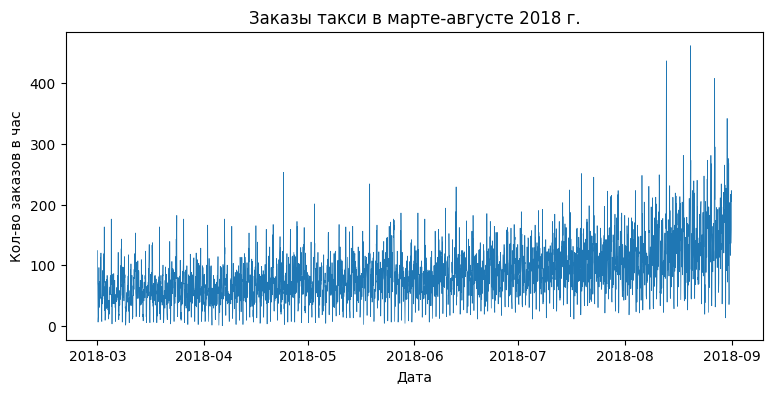

In [11]:
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов в час')
plt.title('Заказы такси в марте-августе 2018 г.')
plt.plot(df, linewidth=0.5)
plt.show()

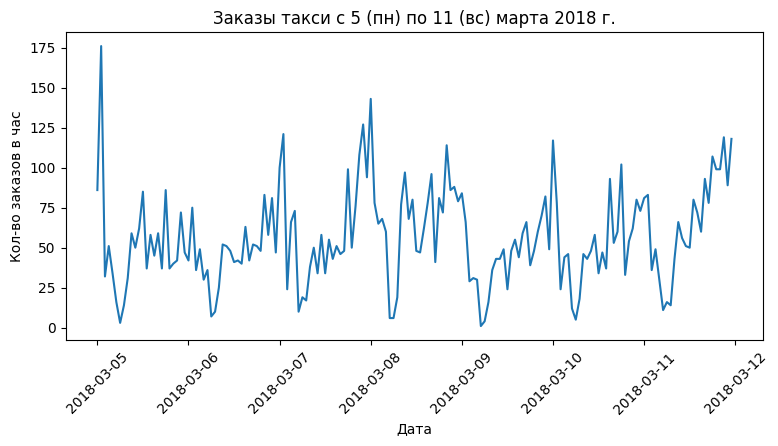

In [12]:
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов в час')
plt.title('Заказы такси с 5 (пн) по 11 (вс) марта 2018 г.')
plt.plot(df['2018-03-05':'2018-03-11'])
plt.xticks(rotation=45)
plt.show()

**Вывод.** Заметен тренд на увеличение заказов с начала лета и особенно в августе, что, разумеется, связано с сезоном отпусков. Заметна также "стохастическая" суточная цикличность

### Среднее и скользящее среднее

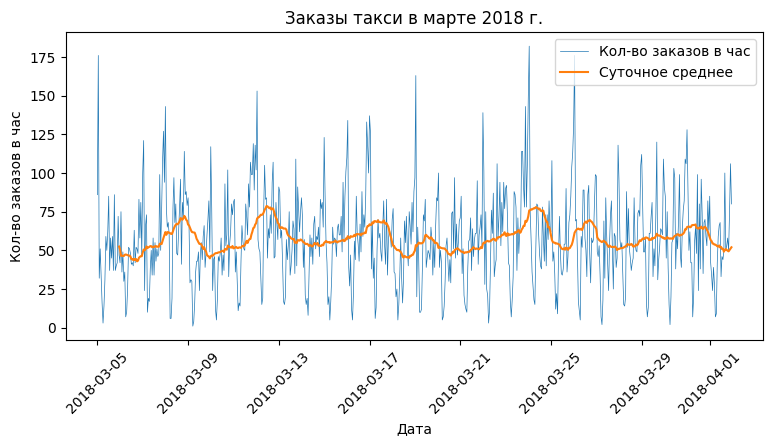

In [13]:
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов в час')

# количество заказов за 4 полных недели
plt.plot(df['2018-03-05':'2018-04-01'], linewidth=0.5)
# суточное среднее
plt.plot(df['2018-03-05':'2018-04-01'].rolling(24).mean())

plt.title('Заказы такси в марте 2018 г.')
plt.legend(['Кол-во заказов в час', 'Суточное среднее'])
plt.xticks(rotation=45)
plt.show()

**Вывод.** Всплески числа заказов связаны с окончанием и началом рабочей недели (пт, пн), но эта цикличность нерегулярная.

Посмотрим средние значения по дням недели в разные месяцы

In [14]:
df_days = df.copy()

In [15]:
df_days['weekday'] = df_days.index.dayofweek
df_days['month'] = df_days.index.month

In [16]:
df_days.head()

num_orders  weekday  month
datetime                                       
2018-03-01 00:00:00         124        3      3
2018-03-01 01:00:00          85        3      3
2018-03-01 02:00:00          71        3      3
2018-03-01 03:00:00          66        3      3
2018-03-01 04:00:00          43        3      3

In [17]:
# названия для цифровых меток
weekdays = {0:'пн', 1:'вт', 2:'ср', 3:'чт', 
            4:'пт', 5:'сб', 6:'вс'}
months = {3:'март', 4:'апрель', 5:'май', 
          6:'июнь', 7:'июль', 8:'август'}

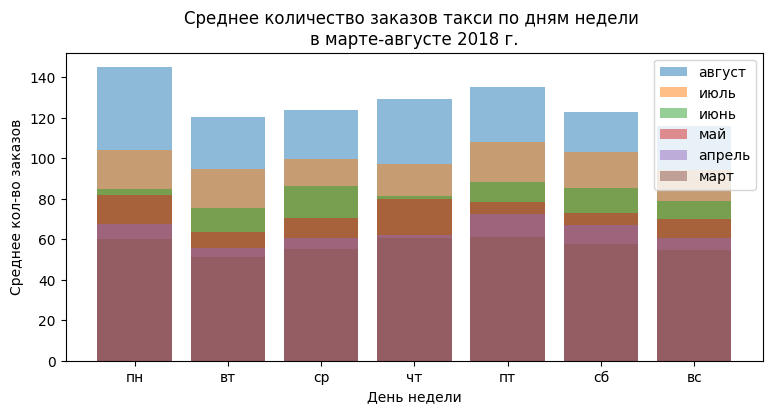

In [18]:
# диаграммы среднего числа заказов
plt.plot(figsize=(9,6))
plt.title('Среднее количество заказов такси '+\
          'по дням недели \nв марте-августе 2018 г.')
for m in range(8, 2, -1):
    df_m = df_days[df_days['month'] == m].groupby(['weekday'])\
                                         .mean()['num_orders']
    plt.bar(df_m.index, 
            df_m, 
            label=months[m], 
            alpha=0.5)    
plt.xticks(ticks=list(weekdays.keys()), 
           labels=list(weekdays.values()))
plt.xlabel('День недели')
plt.ylabel('Среднее кол-во заказов')
plt.legend()
plt.show()

**Вывод.** Недельный тренд распределения числа среднего числа заказов "цикличен" в течение всего рассматриваемого периода. 

Наибольшее среднее число заказов было в ПН и ПТ, наименьшее - во ВТ и ВС. В августе число заказов ежедневно на 20+% больше, чем в предыдущие месяцы, в частности, в ПН в августе заказов почти в 2 раза больше, чем в мае и июне

### Тренды и цикличность

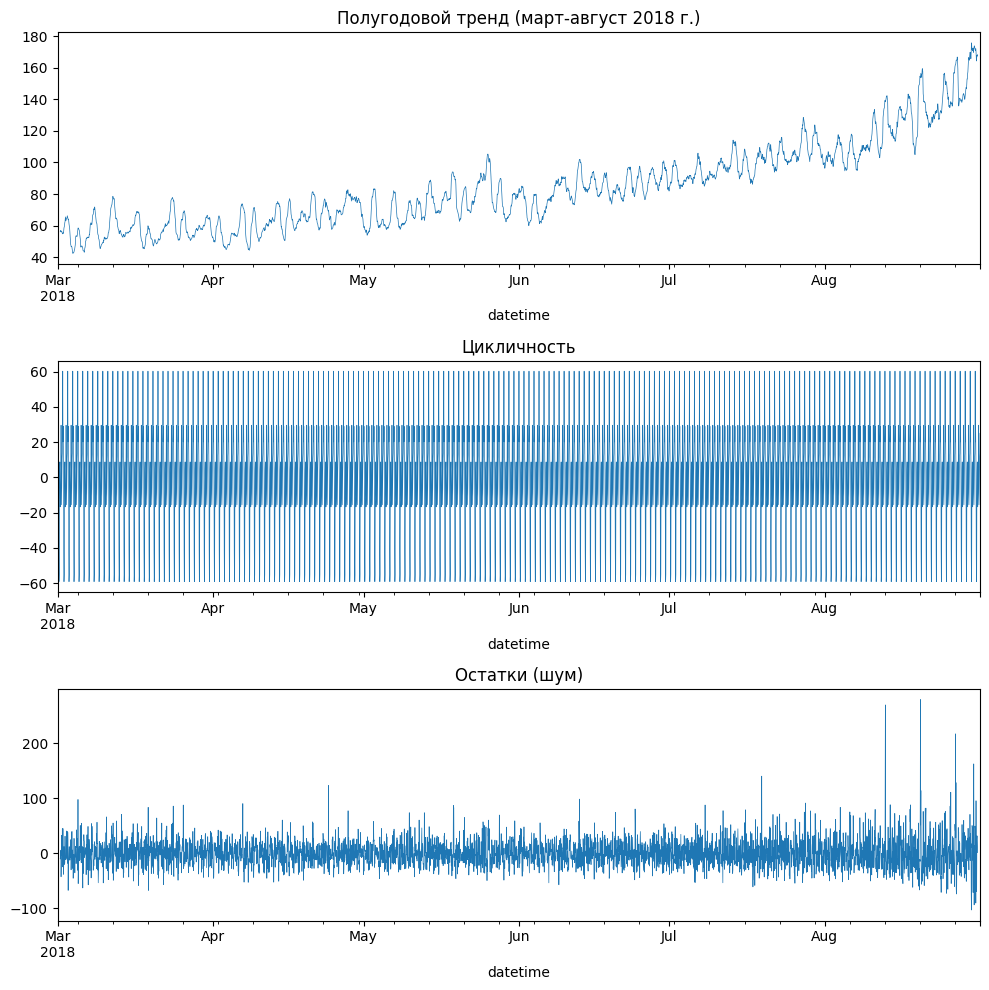

In [19]:
# по всему датасету
decomposed = seasonal_decompose(df)

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(linewidth=0.5)
plt.title('Полугодовой тренд (март-август 2018 г.)')

plt.subplot(312)
decomposed.seasonal.plot(linewidth=0.5)
plt.title('Цикличность')

plt.subplot(313)
decomposed.resid.plot(linewidth=0.5)
plt.title('Остатки (шум)')

plt.tight_layout()

**Вывод.** Тенденции, которые отметили выше, подтвердились. По графику шума видно, что общий тренд на увеличение числа заказов летом имеет наиболее сильные случайные колебания именно в конце августа, что, вероятно, связано с массовыми прилетами и улетами отпускников в этом временном промежутке. 

Посмотрим более короткие временные отрезки:

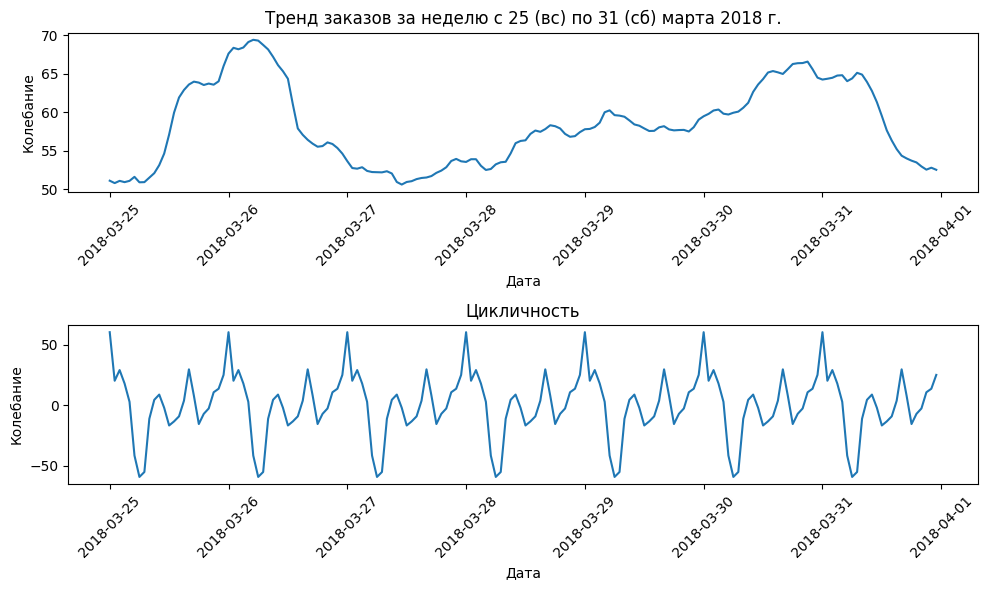

In [20]:
# за одну полную неделю:
sn = '2018-03-25'
st = '2018-03-31'
plt.figure(figsize=(10,6))

plt.subplot(211)
plt.plot(decomposed.trend[sn:st])
plt.title('Тренд заказов за неделю с 25 (вс) по 31 (сб) марта 2018 г.')
plt.xlabel('Дата')
plt.ylabel('Колебание')
plt.xticks(rotation=45)

plt.subplot(212)
plt.plot(decomposed.seasonal[sn:st])
plt.title('Цикличность')
plt.xlabel('Дата')
plt.ylabel('Колебание')
plt.xticks(rotation=45)

plt.tight_layout()

**Вывод.** В понедельник и пятницу заказов больше всего - это мы уже поняли. Наблюдается также суточная цикличность - посмотрим ее подробнее

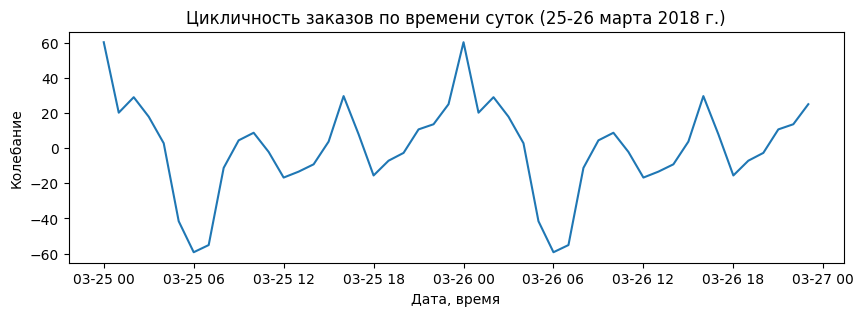

In [21]:
plt.figure(figsize=(10,3))
plt.plot(decomposed.seasonal['2018-03-25 00:00':'2018-03-26 23:00'])
plt.title('Цикличность заказов по времени суток (25-26 марта 2018 г.)')
plt.xlabel('Дата, время')
plt.ylabel('Колебание')
plt.show()

**Вывод.** В течение суток пики заказов приходится на 16.30-17.00 (возвращение с работы) и на полночь (возвращение из заведений), минимум - на 6 утра (большинство уже/еще спят). Наблюдается нечто вроде цикличности с 6-часовым периодом

### Степень стационарности временного ряда

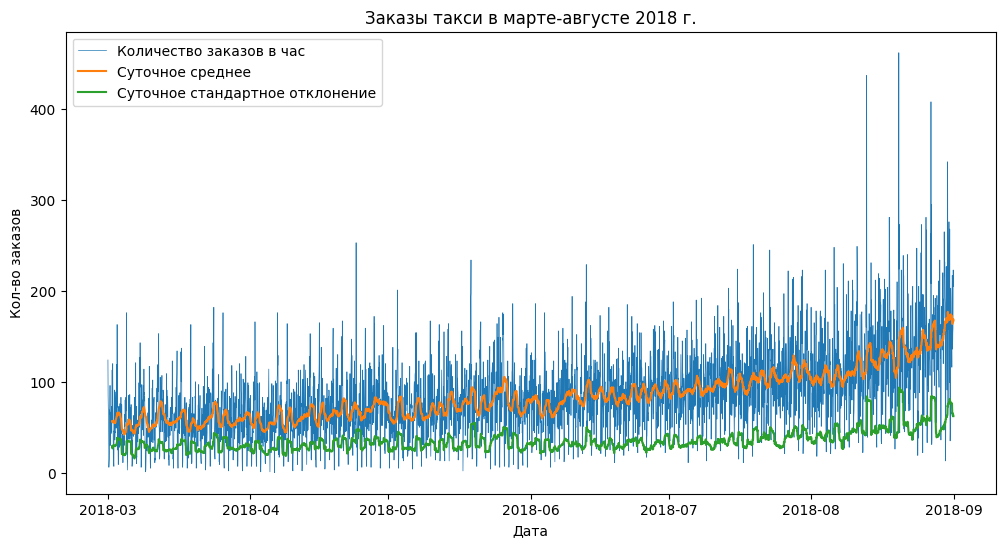

In [22]:
plt.figure(figsize=(12,6))
plt.plot(df, linewidth=0.5)
plt.plot(df.rolling(24).mean())
plt.plot(df.rolling(24).std())
plt.title('Заказы такси в марте-августе 2018 г.')
plt.legend(['Количество заказов в час', 
            'Суточное среднее', 
            'Суточное стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')
plt.show()

**Вывод.** Как уже было видно по графику шума, наибольшие отклонения от стационарности характерны для конечного отрезка ряда (вторая половина августа). Одна из возможных причин - влияние графика отпусков и, соответственно, конкретных дат прилетов и отлетов.

Посмотрим этот отрезок ряда подробнее с разным периодом скользящего среднего:

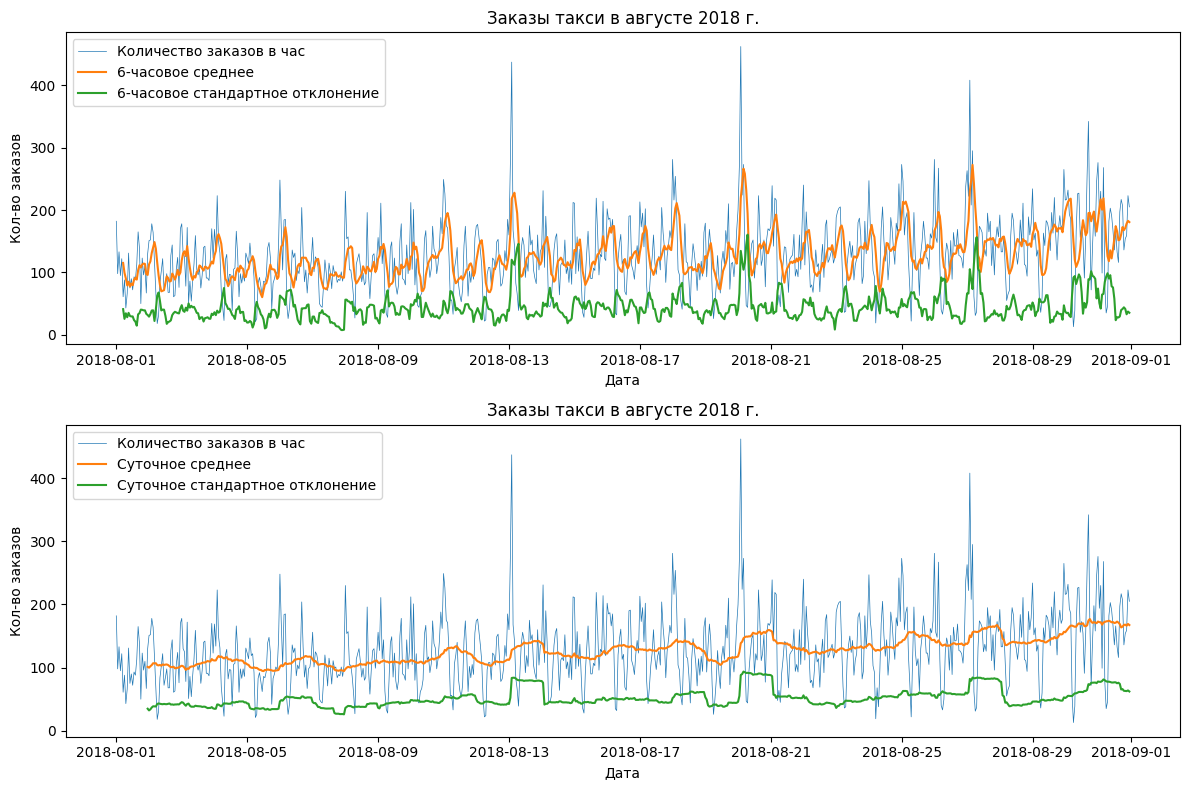

In [23]:
plt.figure(figsize=(12,8))
aug_1 = '2018-08-01'
aug_31 = '2018-08-31'

plt.subplot(211)
plt.plot(df[aug_1:aug_31], linewidth=0.5)
plt.plot(df[aug_1:aug_31].rolling(6).mean())
plt.plot(df[aug_1:aug_31].rolling(6).std())
plt.title('Заказы такси в августе 2018 г.')
plt.legend(['Количество заказов в час', 
            '6-часовое среднее', 
            '6-часовое стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(212)
plt.plot(df[aug_1:aug_31], linewidth=0.5)
plt.plot(df[aug_1:aug_31].rolling(24).mean())
plt.plot(df[aug_1:aug_31].rolling(24).std())
plt.title('Заказы такси в августе 2018 г.')
plt.legend(['Количество заказов в час', 
            'Суточное среднее', 
            'Суточное стандартное отклонение'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.tight_layout()

**Вывод.** По графикам 6-часового среднего и стандартного отклонения хорошо видна 6-часовая псевдоцикличность, которую уже отметили выше. 

На посуточных графиках по-прежнему видны всплески числа заказов в опреленные дни недели (как уже видели выше, скорее всего - ПН и ПТ). Оценим их точнее:

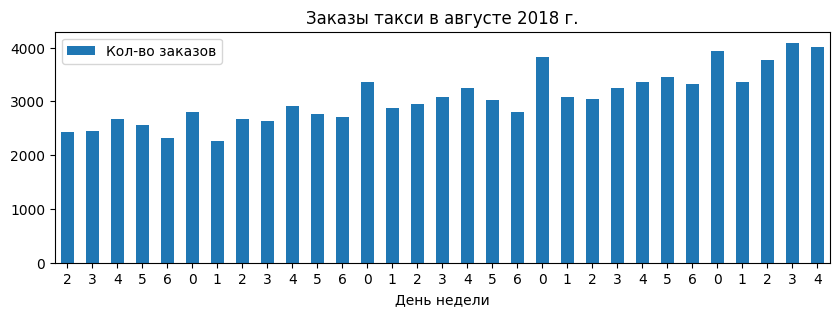

In [24]:
# ресемплирование по 1 дню
df_aug = df[aug_1:aug_31].resample('1D').sum()
df_aug_days = pd.DataFrame({'День недели':df_aug.index.dayofweek,
                            'Кол-во заказов':df_aug['num_orders']})
df_aug_days.plot.bar(x='День недели', 
                     y='Кол-во заказов',
                     figsize=(10,3),
                     rot=0)
plt.title('Заказы такси в августе 2018 г.')
plt.show()

**Вывод.** Во второй половине августа максимальный пик числа заказов приходится на понедельник, второй (меньший) в течение недели пик - в пятницу, минимум заказов - в среду. 

В последние 3 дня месяца пик заказов, сравнимый с понедельничным, очевидно, связан с окончанием лета и наиболее массовым возвращением отпускников

### Разности временного ряда

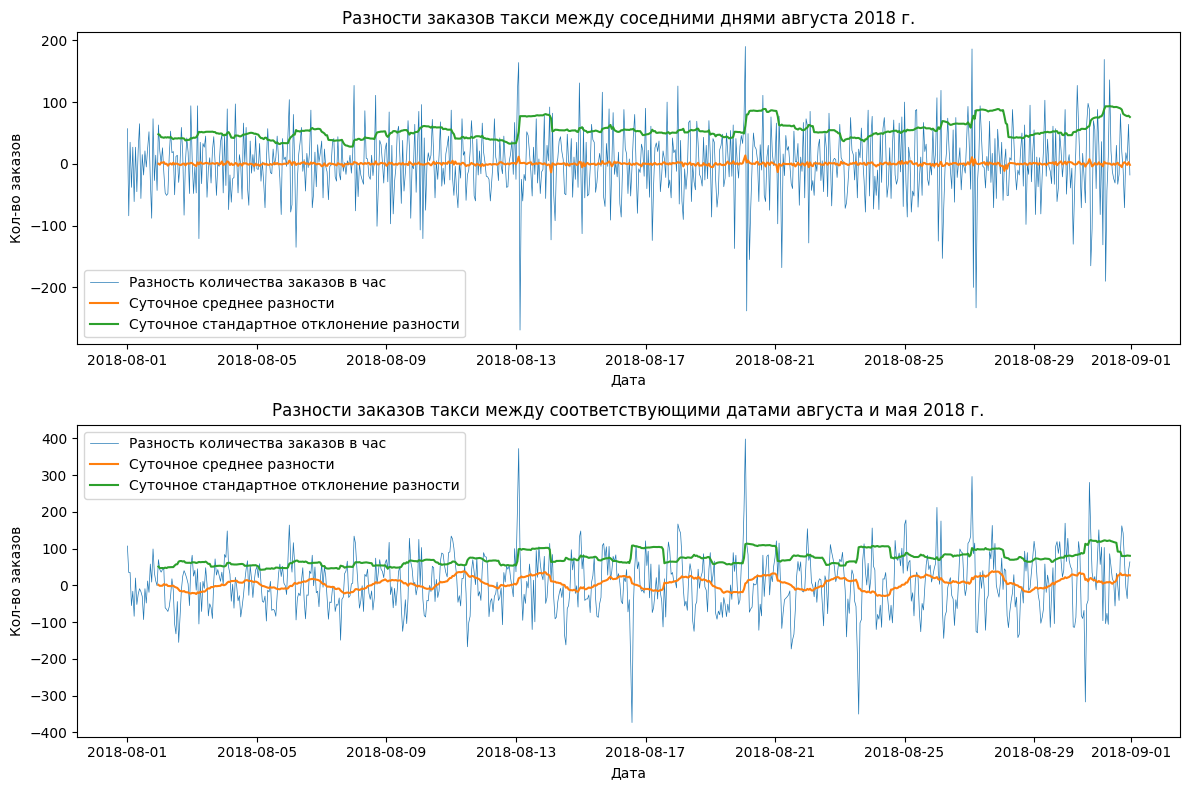

In [25]:
# ряд разностей соседних дней
shifted_df = df - df.shift()

# ряд разностей дней со сдвигом на 
# половину датасета - 3 месяца (3*28=84 дня)
# т.е. смотрим разности одинаковых дат мая и августа
shifted_half_df = df - df.shift(84)

plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(shifted_df[aug_1:aug_31], linewidth=0.5)
plt.plot(shifted_df[aug_1:aug_31].rolling(24).mean())
plt.plot(shifted_df[aug_1:aug_31].rolling(24).std())
plt.title('Разности заказов такси между соседними днями августа 2018 г.')
plt.legend(['Разность количества заказов в час', 
            'Суточное среднее разности', 
            'Суточное стандартное отклонение разности'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.subplot(212)
plt.plot(shifted_half_df[aug_1:aug_31], linewidth=0.5)
plt.plot(shifted_half_df[aug_1:aug_31].rolling(24).mean())
plt.plot(shifted_half_df[aug_1:aug_31].rolling(24).std())
plt.title('Разности заказов такси между соответствующими '+\
          'датами августа и мая 2018 г.')
plt.legend(['Разность количества заказов в час', 
            'Суточное среднее разности', 
            'Суточное стандартное отклонение разности'])
plt.xlabel('Дата')
plt.ylabel('Кол-во заказов')

plt.tight_layout()

**Вывод.** 
1. Максимальные колебания на графике разности соседних дней по понедельникам сохранились. Суточное среднее разности более гладкое и незначительно колеблется около нуля. Профиль кривой стандартного отклонения разности мало отличается от кривой стандартного отклонения количества
2. Максимальные положительные колебания на графике разности одинаковых дат мая-августа по понедельникам сохранились, отрицательные сместились на середину недели. Суточное среднее разности почти превратилось в синусоиду. Профиль кривой стандартного отклонения разности сохранился, но период ступенчатых колебаний уменьшился в 2 раза.

В п.2 всё очень странно - нечаянно обнаружили либо некое фундаметнальное свойство временного ряда, либо (что вероятнее) синтетический характер данных

### Выборки. Календарные признаки и их корреляции

In [26]:
# делим выборки 9:1
train, test = train_test_split(df, 
                               shuffle=False, 
                               test_size=0.1)

In [27]:
# проверим границу разделения
train.index.max()

Timestamp('2018-08-13 13:00:00')

In [28]:
test.index.min()

Timestamp('2018-08-13 14:00:00')

In [29]:
def make_features(data, 
                  max_lag, 
                  rolling_mean_size):
    '''функция для выделения календарных признаков,'''
    '''временнЫх лагов и скользящего среднего'''
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[
            'num_orders'].shift(lag)
    data['rolling_mean_{}'.format(rolling_mean_size)] =\
        data['num_orders'].shift()\
        .rolling(rolling_mean_size)\
        .mean()

Новые признаки, в том чисоле лаги, создадим на обучающей и тестовой выборках по отдельности - во избежание утечки данных.

Для выделения контраста циклических тенденций добавим $24\cdot7=168$ временных лагов по числу часов в одной неделе

In [30]:
# преобразование обучающей выборки
train_featured = train.copy()
# добавим лаги и суточное среднее
make_features(train_featured, 24*7, 24)

# оставляем только полностью заполненные строки
train_featured = train_featured['2018-03-08 00:00':]
train_featured.head()

num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-08 00:00:00         143    8          3     0   94.0  127.0  108.0   
2018-03-08 01:00:00          78    8          3     1  143.0   94.0  127.0   
2018-03-08 02:00:00          65    8          3     2   78.0  143.0   94.0   
2018-03-08 03:00:00          68    8          3     3   65.0   78.0  143.0   
2018-03-08 04:00:00          60    8          3     4   68.0   65.0   78.0   

                     lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                        
2018-03-08 00:00:00   76.0   50.0   99.0   48.0   46.0   51.0    43.0    55.0   
2018-03-08 01:00:00  108.0   76.0   50.0   99.0   48.0   46.0    51.0    43.0   
2018-03-08 02:00:00  127.0  108.0   76.0   50.0   99.0   48.0    46.0    51.0   
2018-03-08 03:00:00   94.0  127.0  108.0   76.0   50.0   99.0    48.0    46.0   
2018-03-08 04:00:00  143.0   94.0  127.0  108.0   76.0   50.0    99.0    48.0   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
datetime                                                                      
2018-03-08 00:00:00    34.0    58.0    34.0    50.0    38.0    17.0    19.0   
2018-03-08 01:00:00    55.0    34.0    58.0    34.0    50.0    38.0    17.0   
2018-03-08 02:00:00    43.0    55.0    34.0    58.0    34.0    50.0    38.0   
2018-03-08 03:00:00    51.0    43.0    55.0    34.0    58.0    34.0    50.0   
2018-03-08 04:00:00    46.0    51.0    43.0    55.0    34.0    58.0    34.0   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  lag_25  \
datetime                                                                      
2018-03-08 00:00:00    10.0    73.0    66.0    24.0   121.0   100.0    47.0   
2018-03-08 01:00:00    19.0    10.0    73.0    66.0    24.0   121.0   100.0   
2018-03-08 02:00:00    17.0    19.0    10.0    73.0    66.0    24.0   121.0   
2018-03-08 03:00:00    38.0    17.0    19.0    10.0    73.0    66.0    24.0   
2018-03-08 04:00:00    50.0    38.0    17.0    19.0    10.0    73.0    66.0   

                     lag_26  lag_27  lag_28  lag_29  lag_30  lag_31  lag_32  \
datetime                                                                      
2018-03-08 00:00:00    81.0    58.0    83.0    48.0    51.0    52.0    42.0   
2018-03-08 01:00:00    47.0    81.0    58.0    83.0    48.0    51.0    52.0   
2018-03-08 02:00:00   100.0    47.0    81.0    58.0    83.0    48.0    51.0   
2018-03-08 03:00:00   121.0   100.0    47.0    81.0    58.0    83.0    48.0   
2018-03-08 04:00:00    24.0   121.0   100.0    47.0    81.0    58.0    83.0   

                     lag_33  lag_34  lag_35  lag_36  lag_37  lag_38  lag_39  \
datetime                                                                      
2018-03-08 00:00:00    63.0    40.0    42.0    41.0    48.0    51.0    52.0   
2018-03-08 01:00:00    42.0    63.0    40.0    42.0    41.0    48.0    51.0   
2018-03-08 02:00:00    52.0    42.0    63.0    40.0    42.0    41.0    48.0   
2018-03-08 03:00:00    51.0    52.0    42.0    63.0    40.0    42.0    41.0   
2018-03-08 04:00:00    48.0    51.0    52.0    42.0    63.0    40.0    42.0   

                     lag_40  lag_41  lag_42  lag_43  lag_44  lag_45  lag_46  \
datetime                                                                      
2018-03-08 00:00:00    25.0    10.0     7.0    36.0    30.0    49.0    36.0   
2018-03-08 01:00:00    52.0    25.0    10.0     7.0    36.0    30.0    49.0   
2018-03-08 02:00:00    51.0    52.0    25.0    10.0     7.0    36.0    30.0   
2018-03-08 03:00:00    48.0    51.0    52.0    25.0    10.0     7.0    36.0   
2018-03-08 04:00:00    41.0    48.0    51.0    52.0    25.0    10.0     7.0   

                     lag_47  lag_48  lag_49  lag_50  lag_51  lag_52  lag_53  \
datetime                                                 

In [31]:
# смотрим корреляции на обучающей выборке, 
# используя коэф. Спирмена, т.к. есть ранговые переменные
train_featured.corr(method='spearman').style.background_gradient(cmap='coolwarm')

**Вывод.** Каждый лаг заметно коррелирует с соседними 2-3 лагами, а также с суточным средним, которое также умеренно коррелирует с числом заказов. 

День месяца, день недели и час заказа почти не коррелируют с числом заказов или между собой. Имеется необычная умеренная корреляция 19-20-го лагов с часом заказа (может быть, это связано с синтетическим характером данных).

Сильнее всего с числом заказов коррелирует 168-й лаг. Во избежание большого числа признаков и мультиколлинеарности будем использовать 168-й лаг и суточное среднее, т.к. они слабо коррелируют друг с другом, а также ранговые признаки (день месяца,  день недели и час заказа) - они могут оказаться полезными для древесных моделей

In [32]:
features = ['day', 'dayofweek', 'hour', 
            'lag_168', 'rolling_mean_24']

In [33]:
X_train = train_featured[features].copy()
X_train

day  dayofweek  hour  lag_168  rolling_mean_24
datetime                                                           
2018-03-08 00:00:00    8          3     0    124.0        60.041667
2018-03-08 01:00:00    8          3     1     85.0        61.833333
2018-03-08 02:00:00    8          3     2     71.0        60.041667
2018-03-08 03:00:00    8          3     3     66.0        61.750000
2018-03-08 04:00:00    8          3     4     43.0        61.833333
...                  ...        ...   ...      ...              ...
2018-08-13 09:00:00   13          0     9    136.0       134.041667
2018-08-13 10:00:00   13          0    10    124.0       135.250000
2018-08-13 11:00:00   13          0    11    131.0       137.250000
2018-08-13 12:00:00   13          0    12     87.0       139.875000
2018-08-13 13:00:00   13          0    13    104.0       138.583333

[3806 rows x 5 columns]

In [34]:
y_train = train_featured['num_orders'].copy()
y_train

datetime
2018-03-08 00:00:00    143
2018-03-08 01:00:00     78
2018-03-08 02:00:00     65
2018-03-08 03:00:00     68
2018-03-08 04:00:00     60
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: h, Name: num_orders, Length: 3806, dtype: int64

In [35]:
# преобразование тестовой выборки
test_featured = test.copy()
make_features(test_featured, 24*7, 24)

# оставляем только полностью заполненные строки
test_featured = test_featured['2018-08-20 14:00':]
test_featured.head()

num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-08-20 14:00:00         112   20          0    14  122.0   91.0  152.0   
2018-08-20 15:00:00         223   20          0    15  112.0  122.0   91.0   
2018-08-20 16:00:00         172   20          0    16  223.0  112.0  122.0   
2018-08-20 17:00:00         111   20          0    17  172.0  223.0  112.0   
2018-08-20 18:00:00         122   20          0    18  111.0  172.0  223.0   

                     lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  lag_10  lag_11  \
datetime                                                                        
2018-08-20 14:00:00  146.0  122.0   94.0   44.0   47.0  118.0   273.0   224.0   
2018-08-20 15:00:00  152.0  146.0  122.0   94.0   44.0   47.0   118.0   273.0   
2018-08-20 16:00:00   91.0  152.0  146.0  122.0   94.0   44.0    47.0   118.0   
2018-08-20 17:00:00  122.0   91.0  152.0  146.0  122.0   94.0    44.0    47.0   
2018-08-20 18:00:00  112.0  122.0   91.0  152.0  146.0  122.0    94.0    44.0   

                     lag_12  lag_13  lag_14  lag_15  lag_16  lag_17  lag_18  \
datetime                                                                      
2018-08-20 14:00:00   462.0   272.0   200.0   167.0   121.0    93.0   116.0   
2018-08-20 15:00:00   224.0   462.0   272.0   200.0   167.0   121.0    93.0   
2018-08-20 16:00:00   273.0   224.0   462.0   272.0   200.0   167.0   121.0   
2018-08-20 17:00:00   118.0   273.0   224.0   462.0   272.0   200.0   167.0   
2018-08-20 18:00:00    47.0   118.0   273.0   224.0   462.0   272.0   200.0   

                     lag_19  lag_20  lag_21  lag_22  lag_23  lag_24  lag_25  \
datetime                                                                      
2018-08-20 14:00:00   114.0    73.0   210.0   147.0   167.0   113.0   134.0   
2018-08-20 15:00:00   116.0   114.0    73.0   210.0   147.0   167.0   113.0   
2018-08-20 16:00:00    93.0   116.0   114.0    73.0   210.0   147.0   167.0   
2018-08-20 17:00:00   121.0    93.0   116.0   114.0    73.0   210.0   147.0   
2018-08-20 18:00:00   167.0   121.0    93.0   116.0   114.0    73.0   210.0   

                     lag_26  lag_27  lag_28  lag_29  lag_30  lag_31  lag_32  \
datetime                                                                      
2018-08-20 14:00:00   117.0    67.0    90.0   127.0    79.0    49.0    26.0   
2018-08-20 15:00:00   134.0   117.0    67.0    90.0   127.0    79.0    49.0   
2018-08-20 16:00:00   113.0   134.0   117.0    67.0    90.0   127.0    79.0   
2018-08-20 17:00:00   167.0   113.0   134.0   117.0    67.0    90.0   127.0   
2018-08-20 18:00:00   147.0   167.0   113.0   134.0   117.0    67.0    90.0   

                     lag_33  lag_34  lag_35  lag_36  lag_37  lag_38  lag_39  \
datetime                                                                      
2018-08-20 14:00:00    73.0   143.0   169.0   134.0    93.0   179.0   164.0   
2018-08-20 15:00:00    26.0    73.0   143.0   169.0   134.0    93.0   179.0   
2018-08-20 16:00:00    49.0    26.0    73.0   143.0   169.0   134.0    93.0   
2018-08-20 17:00:00    79.0    49.0    26.0    73.0   143.0   169.0   134.0   
2018-08-20 18:00:00   127.0    79.0    49.0    26.0    73.0   143.0   169.0   

                     lag_40  lag_41  lag_42  lag_43  lag_44  lag_45  lag_46  \
datetime                                                                      
2018-08-20 14:00:00    94.0   118.0    88.0   114.0    71.0   107.0   129.0   
2018-08-20 15:00:00   164.0    94.0   118.0    88.0   114.0    71.0   107.0   
2018-08-20 16:00:00   179.0   164.0    94.0   118.0    88.0   114.0    71.0   
2018-08-20 17:00:00    93.0   179.0   164.0    94.0   118.0    88.0   114.0   
2018-08-20 18:00:00   134.0    93.0   179.0   164.0    94.0   118.0    88.0   

                     lag_47  lag_48  lag_49  lag_50  lag_51  lag_52  lag_53  \
datetime                                                 

In [36]:
X_test = test_featured[features].copy()
X_test

day  dayofweek  hour  lag_168  rolling_mean_24
datetime                                                           
2018-08-20 14:00:00   20          0    14    102.0       153.666667
2018-08-20 15:00:00   20          0    15    175.0       153.625000
2018-08-20 16:00:00   20          0    16    144.0       155.958333
2018-08-20 17:00:00   20          0    17    152.0       157.000000
2018-08-20 18:00:00   20          0    18    104.0       152.875000
...                  ...        ...   ...      ...              ...
2018-08-31 19:00:00   31          4    19    113.0       164.875000
2018-08-31 20:00:00   31          4    20    179.0       167.541667
2018-08-31 21:00:00   31          4    21    166.0       168.041667
2018-08-31 22:00:00   31          4    22    242.0       166.416667
2018-08-31 23:00:00   31          4    23    173.0       169.125000

[274 rows x 5 columns]

In [37]:
y_test = test['2018-08-20 14:00':]['num_orders'].copy()
y_test

datetime
2018-08-20 14:00:00    112
2018-08-20 15:00:00    223
2018-08-20 16:00:00    172
2018-08-20 17:00:00    111
2018-08-20 18:00:00    122
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: h, Name: num_orders, Length: 274, dtype: int64

Посмотрим, насколько уменьшилось отношение между тестовой и обучающей выборками после исключения пропусков и обрежем начало обучающей выборки для сохранения отношения $9:1$

In [38]:
len(y_test) / (len(y_test) + len(y_train))

0.06715686274509804

Итак, тестовая выборка сейчас составляет 0,07 от всех данных вместо 0,1. Смотрим, сколько записей надо исключить из обучающей выборки: 

In [39]:
len(y_train) - 9 * len(y_test)

1340

In [40]:
1340 / 24

55.833333333333336

Получается, надо выбросить 55-56 дней. Т.к. обучающая выборка начинается 8 марта, выбрасываем все 24 дня в марте, все 30 дней апреля и пару дней в мае. Начало выборки станет 3 мая:  

In [41]:
X_train = X_train['2018-05-03 00:00':]
X_train

day  dayofweek  hour  lag_168  rolling_mean_24
datetime                                                           
2018-05-03 00:00:00    3          3     0    159.0        65.666667
2018-05-03 01:00:00    3          3     1     51.0        68.291667
2018-05-03 02:00:00    3          3     2     73.0        71.625000
2018-05-03 03:00:00    3          3     3    114.0        74.708333
2018-05-03 04:00:00    3          3     4     58.0        76.833333
...                  ...        ...   ...      ...              ...
2018-08-13 09:00:00   13          0     9    136.0       134.041667
2018-08-13 10:00:00   13          0    10    124.0       135.250000
2018-08-13 11:00:00   13          0    11    131.0       137.250000
2018-08-13 12:00:00   13          0    12     87.0       139.875000
2018-08-13 13:00:00   13          0    13    104.0       138.583333

[2462 rows x 5 columns]

In [42]:
y_train = y_train['2018-05-03 00:00':]
y_train

datetime
2018-05-03 00:00:00    201
2018-05-03 01:00:00    125
2018-05-03 02:00:00    136
2018-05-03 03:00:00    110
2018-05-03 04:00:00     60
                      ... 
2018-08-13 09:00:00    137
2018-08-13 10:00:00    156
2018-08-13 11:00:00    144
2018-08-13 12:00:00     92
2018-08-13 13:00:00    119
Freq: h, Name: num_orders, Length: 2462, dtype: int64

In [43]:
len(y_train) / len(y_test)

8.985401459854014

**Вывод.** Тестовая выборка получилась небольшой и охватывает самую "нестационарную" часть датасета (вторая половина августа), это не позволит сделать качество прогноза максимально высоким

In [44]:
# y_test.head()

## Обучение

In [45]:
# в качестве функции потерь - RMSE
RMSE = make_scorer(MSE, 
                   greater_is_better=False, 
                   squared=False)

In [46]:
# таблица и список для хранения результатов
result = pd.DataFrame({'Модель':[], 
                       'RMSE':[], 
                       'cv':[],
                       'Подбор параметров, с':[],
                       'Обучение, с':[]})
models = []

In [47]:
def trainer(model, params, cv_min=5, cv_max=25):
    '''обучение прогностической модели'''
    '''по шаблону временнОй кросс-валидации'''
    best_score = 100
    best_n_cv = 5
    best_model = None  
    # обучение
    start = time()
    for n_cv in tqdm(range(cv_min, cv_max+1)):
        tscv = TimeSeriesSplit(n_splits=n_cv)
        model_rand = GridSearchCV(estimator=model,
                                  param_grid=params,
                                  scoring=RMSE,
                                  cv=tscv, 
                                  verbose=5, 
                                  n_jobs=-1)
        model_rand.fit(X_train, y_train)
        score = -model_rand.best_score_
        if score < best_score:
            best_score = score
            best_n_cv = n_cv
            best_model = model_rand
    train_time = time() - start       
    print('\nПодбор параметров, с:', train_time,
          '\nЧисло CV-разбиений:', best_n_cv,
          '\nГиперпараметры:', best_model.best_params_)
    # оценка эффективности модели   
    start = time()    
    best_model.fit(X_train, y_train)
    RMSE_train = MSE(y_train, 
                     best_model.predict(X_train), 
                     squared=False)
    fit_time = time() - start
    print('Обучение, с:', fit_time,
          '\nRMSE при обучении', RMSE_train)    
    # сохранение результата    
    models.append(best_model.best_estimator_)
    row = []
    row.extend([model, 
                RMSE_train, 
                best_n_cv,
                train_time, 
                fit_time])
    result.loc[len(result.index)] = row
    return best_model, RMSE_train

### Линейная регрессия

In [48]:
%%time
lin_reg = LinearRegression()

lin_reg_best, lin_reg_rmse = trainer(lin_reg, {})  

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Fitting 5 folds for each of 1 candidates, totalling 5 fits


 19%|███████████████▊                                                                   | 4/21 [00:03<00:11,  1.45it/s]

Fitting 6 folds for each of 1 candidates, totalling 6 fits
Fitting 7 folds for each of 1 candidates, totalling 7 fits
Fitting 8 folds for each of 1 candidates, totalling 8 fits
Fitting 9 folds for each of 1 candidates, totalling 9 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 11 folds for each of 1 candidates, totalling 11 fits


 48%|███████████████████████████████████████                                           | 10/21 [00:03<00:02,  4.70it/s]

Fitting 12 folds for each of 1 candidates, totalling 12 fits
Fitting 13 folds for each of 1 candidates, totalling 13 fits
Fitting 14 folds for each of 1 candidates, totalling 14 fits
Fitting 15 folds for each of 1 candidates, totalling 15 fits
Fitting 16 folds for each of 1 candidates, totalling 16 fits


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:04<00:01,  6.57it/s]

Fitting 17 folds for each of 1 candidates, totalling 17 fits
Fitting 18 folds for each of 1 candidates, totalling 18 fits
Fitting 19 folds for each of 1 candidates, totalling 19 fits
Fitting 20 folds for each of 1 candidates, totalling 20 fits


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:04<00:00,  9.40it/s]

Fitting 21 folds for each of 1 candidates, totalling 21 fits
Fitting 22 folds for each of 1 candidates, totalling 22 fits
Fitting 23 folds for each of 1 candidates, totalling 23 fits
Fitting 24 folds for each of 1 candidates, totalling 24 fits


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:04<00:00,  4.62it/s]

Fitting 25 folds for each of 1 candidates, totalling 25 fits

Подбор параметров, с: 4.548679351806641 
Число CV-разбиений: 22 
Гиперпараметры: {}
Fitting 22 folds for each of 1 candidates, totalling 22 fits
Обучение, с: 0.0706186294555664 
RMSE при обучении 25.71932904417884
CPU times: total: 1.2 s
Wall time: 4.62 s


### Гребневая регрессия

In [49]:
%%time
ridge_reg = Ridge()

ridge_reg_par = {
    'alpha':[0.5, 1.0, 1.5],
    'solver':['svd', 'lsqr', 'sparse_cg']
}

ridge_reg_best, ridge_reg_rmse = trainer(ridge_reg, ridge_reg_par)  

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Fitting 5 folds for each of 9 candidates, totalling 45 fits


  5%|███▉                                                                               | 1/21 [00:00<00:02,  7.04it/s]

Fitting 6 folds for each of 9 candidates, totalling 54 fits


 10%|███████▉                                                                           | 2/21 [00:00<00:02,  6.38it/s]

Fitting 7 folds for each of 9 candidates, totalling 63 fits


 19%|███████████████▊                                                                   | 4/21 [00:00<00:02,  5.91it/s]

Fitting 8 folds for each of 9 candidates, totalling 72 fits
Fitting 9 folds for each of 9 candidates, totalling 81 fits


 29%|███████████████████████▋                                                           | 6/21 [00:01<00:02,  5.74it/s]

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Fitting 11 folds for each of 9 candidates, totalling 99 fits


 33%|███████████████████████████▋                                                       | 7/21 [00:01<00:02,  5.34it/s]

Fitting 12 folds for each of 9 candidates, totalling 108 fits


 38%|███████████████████████████████▌                                                   | 8/21 [00:01<00:02,  4.65it/s]

Fitting 13 folds for each of 9 candidates, totalling 117 fits


 43%|███████████████████████████████████▌                                               | 9/21 [00:01<00:02,  4.15it/s]

Fitting 14 folds for each of 9 candidates, totalling 126 fits


 48%|███████████████████████████████████████                                           | 10/21 [00:02<00:02,  4.12it/s]

Fitting 15 folds for each of 9 candidates, totalling 135 fits


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:02<00:02,  3.95it/s]

Fitting 16 folds for each of 9 candidates, totalling 144 fits


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:02<00:02,  3.81it/s]

Fitting 17 folds for each of 9 candidates, totalling 153 fits


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:02<00:02,  3.50it/s]

Fitting 18 folds for each of 9 candidates, totalling 162 fits


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:03<00:02,  3.32it/s]

Fitting 19 folds for each of 9 candidates, totalling 171 fits


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [00:03<00:01,  3.17it/s]

Fitting 20 folds for each of 9 candidates, totalling 180 fits


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [00:04<00:01,  3.01it/s]

Fitting 21 folds for each of 9 candidates, totalling 189 fits


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [00:04<00:01,  2.88it/s]

Fitting 22 folds for each of 9 candidates, totalling 198 fits


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [00:04<00:01,  2.72it/s]

Fitting 23 folds for each of 9 candidates, totalling 207 fits


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [00:05<00:00,  2.62it/s]

Fitting 24 folds for each of 9 candidates, totalling 216 fits


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [00:05<00:00,  2.46it/s]

Fitting 25 folds for each of 9 candidates, totalling 225 fits


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:06<00:00,  3.40it/s]



Подбор параметров, с: 6.174908399581909 
Число CV-разбиений: 22 
Гиперпараметры: {'alpha': 1.5, 'solver': 'lsqr'}
Fitting 22 folds for each of 9 candidates, totalling 198 fits
Обучение, с: 0.41501927375793457 
RMSE при обучении 25.719329044275046
CPU times: total: 4.17 s
Wall time: 6.59 s


**Вывод.** При равной эффективности быстрее обычная линейная регрессия (без регуляризации)

### LightGBM

In [50]:
%%time
lgb_reg = LGBMRegressor(num_threads=2)

lgb_reg_par = {
    'max_depth': [3, 5, 8, 15],
    'learning_rate': [0.05, 0.1, 0.15]
}

lgb_reg_best, lgb_reg_rmse = trainer(lgb_reg, lgb_reg_par)

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


  5%|███▉                                                                               | 1/21 [00:02<00:41,  2.07s/it]

[LightGBM] [Warning] num_threads is set=2, n_jobs=-1 will be ignored. Current value: num_threads=2
Fitting 6 folds for each of 12 candidates, totalling 72 fits


 10%|███████▉                                                                           | 2/21 [00:04<00:40,  2.14s/it]

Fitting 7 folds for each of 12 candidates, totalling 84 fits


 14%|███████████▊                                                                       | 3/21 [00:06<00:41,  2.33s/it]

Fitting 8 folds for each of 12 candidates, totalling 96 fits


 19%|███████████████▊                                                                   | 4/21 [00:09<00:43,  2.55s/it]

Fitting 9 folds for each of 12 candidates, totalling 108 fits


 24%|███████████████████▊                                                               | 5/21 [00:12<00:44,  2.77s/it]

Fitting 10 folds for each of 12 candidates, totalling 120 fits


 29%|███████████████████████▋                                                           | 6/21 [00:16<00:46,  3.10s/it]

Fitting 11 folds for each of 12 candidates, totalling 132 fits


 33%|███████████████████████████▋                                                       | 7/21 [00:20<00:47,  3.36s/it]

Fitting 12 folds for each of 12 candidates, totalling 144 fits


 38%|███████████████████████████████▌                                                   | 8/21 [00:24<00:46,  3.55s/it]

Fitting 13 folds for each of 12 candidates, totalling 156 fits


 43%|███████████████████████████████████▌                                               | 9/21 [00:28<00:45,  3.80s/it]

Fitting 14 folds for each of 12 candidates, totalling 168 fits


 48%|███████████████████████████████████████                                           | 10/21 [00:33<00:44,  4.09s/it]

Fitting 15 folds for each of 12 candidates, totalling 180 fits


 52%|██████████████████████████████████████████▉                                       | 11/21 [00:38<00:43,  4.40s/it]

Fitting 16 folds for each of 12 candidates, totalling 192 fits


 57%|██████████████████████████████████████████████▊                                   | 12/21 [00:44<00:42,  4.77s/it]

Fitting 17 folds for each of 12 candidates, totalling 204 fits


 62%|██████████████████████████████████████████████████▊                               | 13/21 [00:50<00:41,  5.17s/it]

Fitting 18 folds for each of 12 candidates, totalling 216 fits


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [00:56<00:38,  5.50s/it]

Fitting 19 folds for each of 12 candidates, totalling 228 fits


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [01:02<00:34,  5.75s/it]

Fitting 20 folds for each of 12 candidates, totalling 240 fits


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [01:09<00:30,  6.03s/it]

Fitting 21 folds for each of 12 candidates, totalling 252 fits


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [01:16<00:25,  6.34s/it]

Fitting 22 folds for each of 12 candidates, totalling 264 fits


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [01:24<00:20,  6.74s/it]

Fitting 23 folds for each of 12 candidates, totalling 276 fits


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [01:32<00:14,  7.05s/it]

Fitting 24 folds for each of 12 candidates, totalling 288 fits


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [01:40<00:07,  7.46s/it]

Fitting 25 folds for each of 12 candidates, totalling 300 fits


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [01:49<00:00,  5.19s/it]



Подбор параметров, с: 109.09475564956665 
Число CV-разбиений: 23 
Гиперпараметры: {'learning_rate': 0.05, 'max_depth': 5}
Fitting 23 folds for each of 12 candidates, totalling 276 fits
Обучение, с: 8.205191373825073 
RMSE при обучении 19.92669739137406
CPU times: total: 6.42 s
Wall time: 1min 57s


### CatBoost

In [51]:
# обучается долго, поэтому тут расчет сразу с лучшими параметрами 

In [52]:
%%time
catboost = CatBoostRegressor(verbose=False) 

catboost_par = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05]
}

catboost_best, catboost_rmse = trainer(catboost, catboost_par)

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

Fitting 5 folds for each of 6 candidates, totalling 30 fits


  5%|███▉                                                                               | 1/21 [00:16<05:39, 16.99s/it]

Fitting 6 folds for each of 6 candidates, totalling 36 fits


 10%|███████▉                                                                           | 2/21 [00:36<05:48, 18.32s/it]

Fitting 7 folds for each of 6 candidates, totalling 42 fits


 14%|███████████▊                                                                       | 3/21 [00:57<05:56, 19.82s/it]

Fitting 8 folds for each of 6 candidates, totalling 48 fits


 19%|███████████████▊                                                                   | 4/21 [01:20<05:58, 21.06s/it]

Fitting 9 folds for each of 6 candidates, totalling 54 fits


 24%|███████████████████▊                                                               | 5/21 [01:47<06:10, 23.17s/it]

Fitting 10 folds for each of 6 candidates, totalling 60 fits


 29%|███████████████████████▋                                                           | 6/21 [02:17<06:20, 25.40s/it]

Fitting 11 folds for each of 6 candidates, totalling 66 fits


 33%|███████████████████████████▋                                                       | 7/21 [02:49<06:25, 27.52s/it]

Fitting 12 folds for each of 6 candidates, totalling 72 fits


 38%|███████████████████████████████▌                                                   | 8/21 [03:23<06:23, 29.51s/it]

Fitting 13 folds for each of 6 candidates, totalling 78 fits


 43%|███████████████████████████████████▌                                               | 9/21 [04:01<06:26, 32.21s/it]

Fitting 14 folds for each of 6 candidates, totalling 84 fits


 48%|███████████████████████████████████████                                           | 10/21 [04:42<06:23, 34.89s/it]

Fitting 15 folds for each of 6 candidates, totalling 90 fits


 52%|██████████████████████████████████████████▉                                       | 11/21 [05:26<06:16, 37.64s/it]

Fitting 16 folds for each of 6 candidates, totalling 96 fits


 57%|██████████████████████████████████████████████▊                                   | 12/21 [06:13<06:06, 40.74s/it]

Fitting 17 folds for each of 6 candidates, totalling 102 fits


 62%|██████████████████████████████████████████████████▊                               | 13/21 [07:08<06:00, 45.03s/it]

Fitting 18 folds for each of 6 candidates, totalling 108 fits


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [08:01<05:32, 47.43s/it]

Fitting 19 folds for each of 6 candidates, totalling 114 fits


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [08:57<04:59, 49.91s/it]

Fitting 20 folds for each of 6 candidates, totalling 120 fits


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [09:57<04:24, 52.88s/it]

Fitting 21 folds for each of 6 candidates, totalling 126 fits


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [10:59<03:42, 55.64s/it]

Fitting 22 folds for each of 6 candidates, totalling 132 fits


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [12:05<02:56, 58.72s/it]

Fitting 23 folds for each of 6 candidates, totalling 138 fits


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [13:13<02:03, 61.63s/it]

Fitting 24 folds for each of 6 candidates, totalling 144 fits


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [14:24<01:04, 64.58s/it]

Fitting 25 folds for each of 6 candidates, totalling 150 fits


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [15:39<00:00, 44.73s/it]



Подбор параметров, с: 939.3041706085205 
Число CV-разбиений: 22 
Гиперпараметры: {'learning_rate': 0.01, 'max_depth': 5}
Fitting 22 folds for each of 6 candidates, totalling 132 fits
Обучение, с: 64.31061792373657 
RMSE при обучении 20.998029306904975
CPU times: total: 1min 4s
Wall time: 16min 43s


## Тестирование

In [53]:
result

Модель       RMSE  cv  \
0                                 LinearRegression()  25.719329  22   
1                                            Ridge()  25.719329  22   
2                       LGBMRegressor(num_threads=2)  19.926697  23   
3  <catboost.core.CatBoostRegressor object at 0x0...  20.998029  22   

   Подбор параметров, с  Обучение, с  
0              4.548679     0.070619  
1              6.174908     0.415019  
2            109.094756     8.205191  
3            939.304171    64.310618

**Вывод.** Модель регрессии во много раз быстрее учится, но у модели *LGBMRegressor* поменьше метрика, поэтому на тестовой выборке проверим обе модели 

### Проверка лучшей модели 

In [54]:
# тестирование LGBMRegressor
start = time()
y_pred_lgb = lgb_reg_best.predict(X_test)
lgb_reg_test_rmse = MSE(y_test, 
                        y_pred_lgb, 
                        squared=False)
print('Вычисление предсказаний заняло, с:', time()-start,
      '\nRMSE при тестировании:', lgb_reg_test_rmse,
      '\nНа сколько % RMSE хуже, чем при обучении:', 
      (lgb_reg_test_rmse-lgb_reg_rmse)*100/lgb_reg_rmse)

Вычисление предсказаний заняло, с: 0.006997585296630859 
RMSE при тестировании: 44.196973946992145 
На сколько % RMSE хуже, чем при обучении: 121.79778755572556


In [55]:
# тестирование линейной регрессии
start = time()
y_pred_lin = lin_reg_best.predict(X_test)
lin_reg_test_rmse = MSE(y_test, 
                        y_pred_lin, 
                        squared=False)
print('Вычисление предсказаний заняло, с:', time()-start,
      '\nRMSE при тестировании:', lin_reg_test_rmse,
      '\nНа сколько % RMSE хуже, чем при обучении:', 
      (lin_reg_test_rmse-lin_reg_rmse)*100/lin_reg_rmse)

Вычисление предсказаний заняло, с: 0.008015871047973633 
RMSE при тестировании: 37.89748153847545 
На сколько % RMSE хуже, чем при обучении: 47.35019515236128


**Вывод.** Как и следовало ожидать, древесная модель с бустингом переобучилась и на тестировании едва влезла в ограничение *RMSE*<48, тогда как классическая регрессия показала лучший результат и по скорости работы, и по предсказанию

### График истинных значений и предсказаний

In [56]:
y_pred = pd.Series(data=y_pred_lin, index=y_test.index)

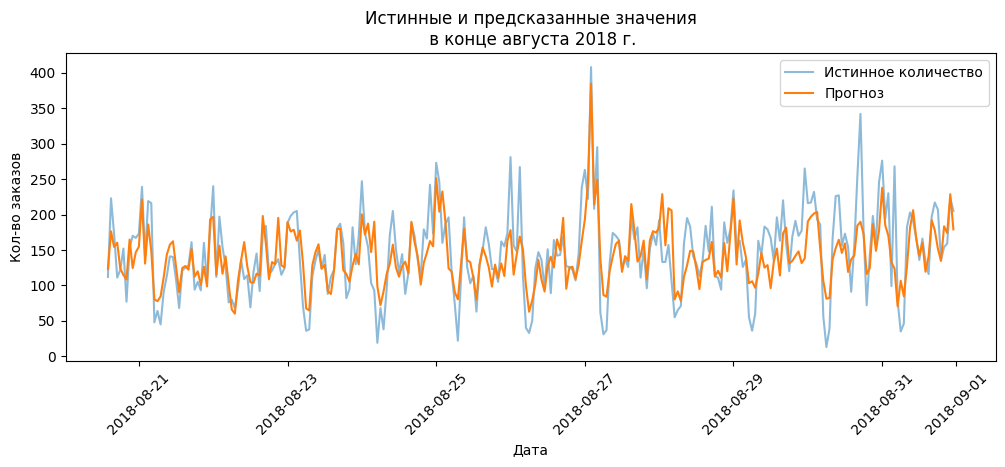

In [57]:
plt.figure(figsize=(12,4))
plt.plot(y_test, alpha=0.5)
plt.plot(y_pred)
plt.title('Истинные и предсказанные значения'+\
          '\n в конце августа 2018 г.')
plt.ylabel('Кол-во заказов')
plt.xlabel('Дата')
plt.legend(['Истинное количество', 'Прогноз'])
plt.xticks(rotation=45)
plt.show()

**Вывод.** Как и ожидалось, значительные случайные колебания числа заказов в конце августа объясняют низкое качество прогноза

### Проверка адекватности
Сравним полученные значения с метриками тривиальных предсказаний: прогноза по предыдущему значению и прогноза по среднему от обучения (используем среднее, а не медиану, т.к. у нас квадратичная метрика)

In [58]:
# наивный прогноз по вчерашнему значению
y_previous = y_test.shift() 
y_previous.iloc[0] = y_train.iloc[y_train.shape[0]-1]
print('RMSE yesterday-модели:', MSE(y_test, 
                                    y_previous, 
                                    squared=False))

RMSE yesterday-модели: 59.99172692355233


In [59]:
# наивный прогноз по среднему обучающей выборки
y_mean = np.ones(y_test.shape) * y_train.mean()
print('RMSE модели прогноза по среднему обучающей выборки:', 
       MSE(y_test, 
           y_mean, 
           squared=False))

RMSE модели прогноза по среднему обучающей выборки: 81.8529042198291


**Вывод.** Построенные модели регрессии и бустинга значительно лучше тривиальнх предсказаний

## Общий вывод

***Предобработка данных*** 

В файле было 26+ тыс записей, без пропусков и дубликатов, о числе заказов такси за март-август 2018 г. с интервалами по 10 мин. В результате ресемплирования по 1 часу  получили 4,4 тыс записей:
- среднее число заказов в час - 84;
- медиана - 78;
- стандартное отклонение - 48.

Очевидно, число заказов сильно колеблется во времени.

***Разведочный анализ***

Заметен тренд на увеличение заказов с начала лета и особенно в августе, что, разумеется, связано с сезоном отпусков. Заметна также "стохастическая" суточная цикличность. 

Недельный тренд распределения числа среднего числа заказов "цикличен" в течение всего рассматриваемого периода. Наибольшее среднее число заказов было в ПН и ПТ, наименьшее - во ВТ и ВС. В августе число заказов ежедневно на 20+% больше, чем в предыдущие месяцы, в частности, в ПН в августе заказов почти в 2 раза больше, чем в мае и июне.

В течение суток пики заказов приходится на 16.30-17.00 (возвращение с работы) и на полночь (возвращение из заведений), минимум - на 6 утра (большинство уже/еще спят). Наблюдается нечто вроде цикличности с 6-часовым периодом.

Наибольшие отклонения от стационарности характерны для конечного отрезка ряда (вторая половина августа). Одна из возможных причин - влияние графика отпусков и, соответственно, конкретных дат прилетов и отлетов. 

При исследовании разностей временного ряда обнаружено, что: 
1. Максимальные колебания на графике разности соседних дней по понедельникам сохранились. Суточное среднее разности более гладкое и незначительно колеблется около нуля. Профиль кривой стандартного отклонения разности мало отличается от кривой стандартного отклонения количества
2. Максимальные положительные колебания на графике разности одинаковых дат мая-августа по понедельникам сохранились, отрицательные сместились на середину недели. Суточное среднее разности почти превратилось в синусоиду. Профиль кривой стандартного отклонения разности сохранился, но период ступенчатых колебаний уменьшился в 2 раза.

Таким образом обнаружили либо некое фундаметнальное свойство данного временного ряда, либо (что вероятнее) синтетический характер данных.

***Выделение новых признаков***

Новые признаки, в том чисоле лаги, создали на обучающей и тестовой выборках по отдельности - во избежание утечки данных. Для выделения контраста циклических тенденций добавили $24\cdot7=168$ временных лагов по числу часов в одной неделе.

Каждый лаг заметно коррелирует с соседними 2-3 лагами, а также с суточным средним, которое также умеренно коррелирует с числом заказов. 

День месяца, день недели и час заказа почти не коррелируют с числом заказов или между собой. Имеется необычная умеренная корреляция 19-20-го лагов с часом заказа (может быть, это связано с синтетическим характером данных).

Сильнее всего с числом заказов коррелирует 168-й лаг. Во избежание большого числа признаков и мультиколлинеарности для обучения использовали 168-й лаг и суточное среднее, т.к. они слабо коррелируют друг с другом, а также ранговые признаки (день месяца, день недели и час заказа) - они могли оказаться полезными для древесных моделей.

Отношение между тестовой и обучающей выборками уменьшилось после исключения пропусков, возникших после создания временных лагов (0,07 от всех данных вместо 0,1).  Для сохранения заданного отношения $9:1$ обрезали начало обучающей выборки на 56 дней. В итоге обучающая выборка охватывала промежуток времени с 3 мая по 13 августа (2462 записи), тестовая - с 20 по 31 августа (274 записи). Тестовая выборка получилась небольшой и охватывает самую "нестационарную" часть датасета (вторая половина августа), это не позволит сделать качество прогноза максимально высоким.

***Обучение прогностических моделей***

При равной эффективности быстрее обычная линейная регрессия (без регуляризации) - при обучении $RMSE=25,7$, общее время подбора параметров и обучения $2$ сек. У модели *LightGBM* при обучении $RMSE=19,9$ и время работы более $300$ сек. Модель регрессии во много раз быстрее учится, но у модели *LightGBM* меньше метрика, поэтому на тестовой выборке проверили обе модели. 

Древесная модель с бустингом переобучилась и на тестировании едва влезла в ограничение $RMSE<48$, классическая регрессия показала лучший результат:
- линейная регрессия: $RMSE=37,9$;
- *LightGBM*: $RMSE=44,2$

Проверка на адекватность пройдена: у тривиального прогноза по предыдущему значению $RMSE=60,0$; у прогноза по среднему от обучения $RMSE=81,9$.

Значительные случайные колебания числа заказов в конце августа объясняют относительно низкое качество прогноза.